https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524

In [ ]:
!pip install textblob

In [ ]:
import findspark
findspark.init()
import pyspark

In [ ]:
# import necessary packages
import os
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from textblob import TextBlob

In [ ]:
def json_load(text):
    return json.loads(text)

In [ ]:
def get_message(text):
    msg = json.loads(text)
    # if tweet is longer than 140 characters
    if "extended_tweet" in msg:
        return str(msg['extended_tweet']['full_text'])
    else:
        return str(msg['text'])

In [ ]:
def get_tweet_field(text, field):
    msg = json.loads(text)
    if '/' in field:
        fields = field.split('/')
        fieldDepth = len(fields)
        f = msg
        for i in range(fieldDepth):
            if(f is None):
                return None
            if i == fieldDepth - 1:
                return str(f[fields[i]]) 
            else:
                f = f[fields[i]]
    else:
        return str(msg[field])

In [ ]:
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
def preprocessing(tweets):
    
    # Convert to json
    json_load_udf = udf(json_load, StringType())
    tweets = tweets.withColumn("json", json_load_udf("value"))
    
    # Get id
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("id", get_tweet_field_udf("value", lit('id')))
    
    # Get created_at
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("created_at", get_tweet_field_udf("value", lit('created_at')))
    
    # Get place full name
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("place_full_name", get_tweet_field_udf("value", lit('place/full_name')))
    
    # Get place country
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("place_country", get_tweet_field_udf("value", lit('place/country')))
    
    # Get place country code
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("place_country_code", get_tweet_field_udf("value", lit('place/country_code')))
    
    # Get message
    get_message_udf = udf(get_message, StringType())
    tweets = tweets.withColumn("message", get_message_udf("value"))
    
    # Get cleaned words from message for analysis
    #tweets = tweets.na.replace('', None)
    #tweets = tweets.na.drop()
    tweets = tweets.withColumn('words', tweets.message)
    tweets = tweets.withColumn('words', F.regexp_replace('words', r'http\S+', ''))
    tweets = tweets.withColumn('words', F.regexp_replace('words', '@\w+', ''))
    tweets = tweets.withColumn('words', F.regexp_replace('words', '#', ''))
    tweets = tweets.withColumn('words', F.regexp_replace('words', 'RT', ''))
    tweets = tweets.withColumn('words', F.regexp_replace('words', ':', ''))
    
    # Drop unnesscessary data
    tweets = tweets.drop("value")
    tweets = tweets.drop("json")
    
    return tweets

In [ ]:
# Text classification using TextBlob
def polarity_detection(text):
    return TextBlob(text).sentiment.polarity
def subjectivity_detection(text):
    return TextBlob(text).sentiment.subjectivity
def text_classification(tweets):
    
    # polarity detection
    polarity_detection_udf = udf(polarity_detection, StringType())
    tweets = tweets.withColumn("polarity", polarity_detection_udf("words"))
    
    # subjectivity detection
    subjectivity_detection_udf = udf(subjectivity_detection, StringType())
    tweets = tweets.withColumn("subjectivity", subjectivity_detection_udf("words"))
    
    # analysis
    get_analysis_udf = udf(get_analysis, StringType())
    tweets = tweets.withColumn('analysis', get_analysis_udf('polarity'))
    
    return tweets

In [ ]:
# create Spark session
#spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()

In [ ]:
# #folderDF = spark.readStream.text('gs://cloud-project-bucket-22/Data/')
# folderDF = spark.read.text('gs://cloud-project-bucket-22/Data/*')
# #folderDF = spark.read.json('gs://cloud-project-bucket-22/Data/*')
# folderDF.isStreaming

In [ ]:
#folderDF.columns
#folderDF.count()

In [ ]:
# tweets = preprocessing(folderDF)
# tweets = text_classification(tweets)

In [ ]:
# tweets.count()

In [ ]:
# tweets.columns

In [ ]:
# tweets.show(50)

In [ ]:
#import libraries to visualize the results from stream
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas

def visualize_results_from_stream():

    get_ipython().run_line_magic('matplotlib', 'inline')
    count = 0
    while count < 5:

        time.sleep(5)
        top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
        top_10_df = top_10_tags.toPandas()
        display.clear_output(wait=True)
        plt.figure( figsize = ( 10, 8 ) )
        sns.barplot( x="count", y="hashtag", data=top_10_df)
        plt.show()
        count = count + 1
        #     print(count)

In [ ]:

# # import necessary packages
# import socket
# from pyspark import SparkContext
# from pyspark.streaming import StreamingContext
# from pyspark.sql import SQLContext
# from pyspark.sql.functions import desc

# def start_stream_processing(spark):
    
#     ssc = StreamingContext(sc, 10)
#     sqlContext = SQLContext(sc)
#     socket_stream = ssc.socketTextStream(socket.gethostname(), 5555)
#     # lines of tweets with socket_stream window of size 60, or 60 #seconds windows of time
#     lines = socket_stream.window(60)
    
#     # just a tuple to assign names
#     from collections import namedtuple
#     fields = ("hashtag", "count" )
#     Tweet = namedtuple( 'Tweet', fields )
#     # here we apply different operations on the tweets and save them to #a temporary sql table
#     (lines.map(lambda tweet: json.loads(text)['text']))
#     .flatMap( lambda text: text.split( " " ))
#         # Lower cases the word
#         .map( lambda word: ( word.lower(), 1 ) )
#         .reduceByKey( lambda a, b: a + b )
#         # Stores in a Tweet Object
#         .map( lambda rec: Tweet( rec[0], rec[1] ) )
#         # Sorts Them in a dataframe
#         .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
#         .limit(10).registerTempTable("tweets") ) )
        
#         # Registers only top 10 words to a table.
# #     ( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
# #       # Checks for    hashtag calls  
# #       #.filter( lambda word: word.lower().startswith("#") ) 
# #       .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
# #       .reduceByKey( lambda a, b: a + b ) 
# #      # Stores in a Tweet Object
# #       .map( lambda rec: Tweet( rec[0], rec[1] ) )
# #      # Sorts Them in a dataframe
# #       .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
# #      # Registers only top 10 hashtags to a table.
# #       .limit(10).registerTempTable("tweets") ) )
    
#     # start streaming and wait couple of minutes to get enought tweets
#     ssc.start()

In [91]:
#import libraries to visualize the results from stream
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def visualize_results_from_batch(tweets):
    
    testDF = tweets.toPandas()
    get_ipython().run_line_magic('matplotlib', 'inline')
    df_2 = testDF.groupby('analysis').count()
    df_2.reset_index(inplace=True)
    #df_2.head()
    sns.barplot(x='analysis', y='id', data=df_2);


In [92]:
def start_batch_processing(spark):
    folderDF = spark.read.text('gs://cloud-project-bucket-22/Data/*')
    tweets = preprocessing(folderDF)
    tweets = text_classification(tweets)
    #tweets.show(5)
    visualize_results_from_batch(tweets)
    return tweets

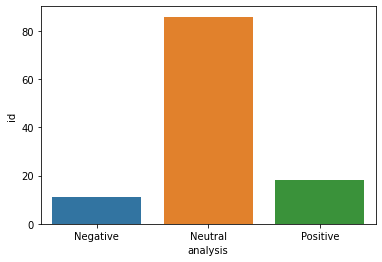

In [93]:
if __name__ == "__main__":

    # Create Spark session
    spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()
    
    # Connect to tweet streaming server
    #start_stream_processing(spark)
    
    # Start batch processing
    start_batch_processing(spark)